# Introdução

Este estudo utiliza um conjunto de dados real e público relacionado à utilização do sistema de transporte público no município de Teresina. O principal objetivo da pesquisa é desenvolver um modelo preditivo capaz de estimar o número de passageiros que utilizam o serviço. Para alcançar esse propósito, foram elaborados dois modelos distintos, a fim de comparar seus desempenhos em termos de capacidade preditiva. O primeiro modelo foi desenvolvido com o uso do Facebook Prophet, uma ferramenta para análise e previsão de séries temporais utilizando modelos clássicos. Já o segundo modelo baseou-se no emprego de redes neurais recorrentes LSTM (Long Short-Term Memory), uma abordagem avançada e eficiente para lidar com dados temporais e não lineares.

Vale destacar que o banco de dados apresenta algumas inconsistências, o que exigiu a realização transformações para viabilizar a análise e o desenvolvimento dos modelos. Conforme novos problemas surgiram, aplicamos técnicas de correção específicas para garantir uma análise mais eficiente. Todo o processo foi conduzido utilizando a linguagem Python, com a utilização de pacotes apropriados conforme a necessidade de cada operação.

In [2]:
import pandas as pd
import numpy as np
import glob 

# neural packages
import torch

# statistical packages
from scipy import stats
from prophet import Prophet
from prophet.plot import plot_components

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# graphics packages
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# configuração dos gráficos 
from matplotlib import rc
# estilo dos gráficos #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('Solarize_Light2')
%config InlineBackend.figure_format = 'retina'  # formato das imagens
rc('font', **{"family":"sans-serif","sans-serif":["DejaVu Sans"], "size":10})
rc('mathtext', **{"default":"regular"})

import warnings
warnings.filterwarnings("ignore")

c:\Users\filip\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Para iniciar o processo de análise de dados, construímos duas funções principais. A primeira, denominada *files()*, tem como objetivo carregar todos os arquivos que serão utilizados. Devido à limitação de o banco de dados não estar conectado a nenhum sistema, como SQL ou algum serviço de cloud, superamos essa dificuldade realizando o download dos dados em períodos mensais.

Após a inclusão dos dados, a função construída realiza a união dos arquivos em um único arquivo para que possamos manipulá-los de forma conjunta.

A função *pas()* constrói outro arquivo com a quantidade de passageiros diários, que será utilizado para realizar a previsão de passageiros.

In [3]:
# Function to load and process dataframes
def load_files(year):  
    # Filter files with the pattern "ano_YY_*.csv"
    file_pattern = f"D:\\OneDrive\\DEV\\public_transportation_THE\\relatorios\\ano_{year}_*.csv"
    all_files = glob.glob(file_pattern)
    
    # Read and concatenate the corresponding CSV files
    df = pd.concat(
        pd.read_csv(f, encoding="ISO-8859-1", on_bad_lines="skip", sep=";", decimal=",") 
        for f in all_files
    )
    
    # Filter trips of type 11 only (removing trips to garages)
    df = df[df["Tipo Viagem"] == 11]
    
    # Convert the 'Data Coleta' column to datetime format
    df["Data Coleta"] = pd.to_datetime(df["Data Coleta"], format="%d/%m/%Y")
    
    # Calculate the total number of passengers per day
    daily = df.groupby("Data Coleta")["Passageiros"].sum().reset_index()
    
    # Add a column with the day of the week (Monday=0, Sunday=6)
    daily["dia_semana"] = daily["Data Coleta"].dt.dayofweek
    
    return daily

# Example usage of the function
freq_pas = load_files(22)

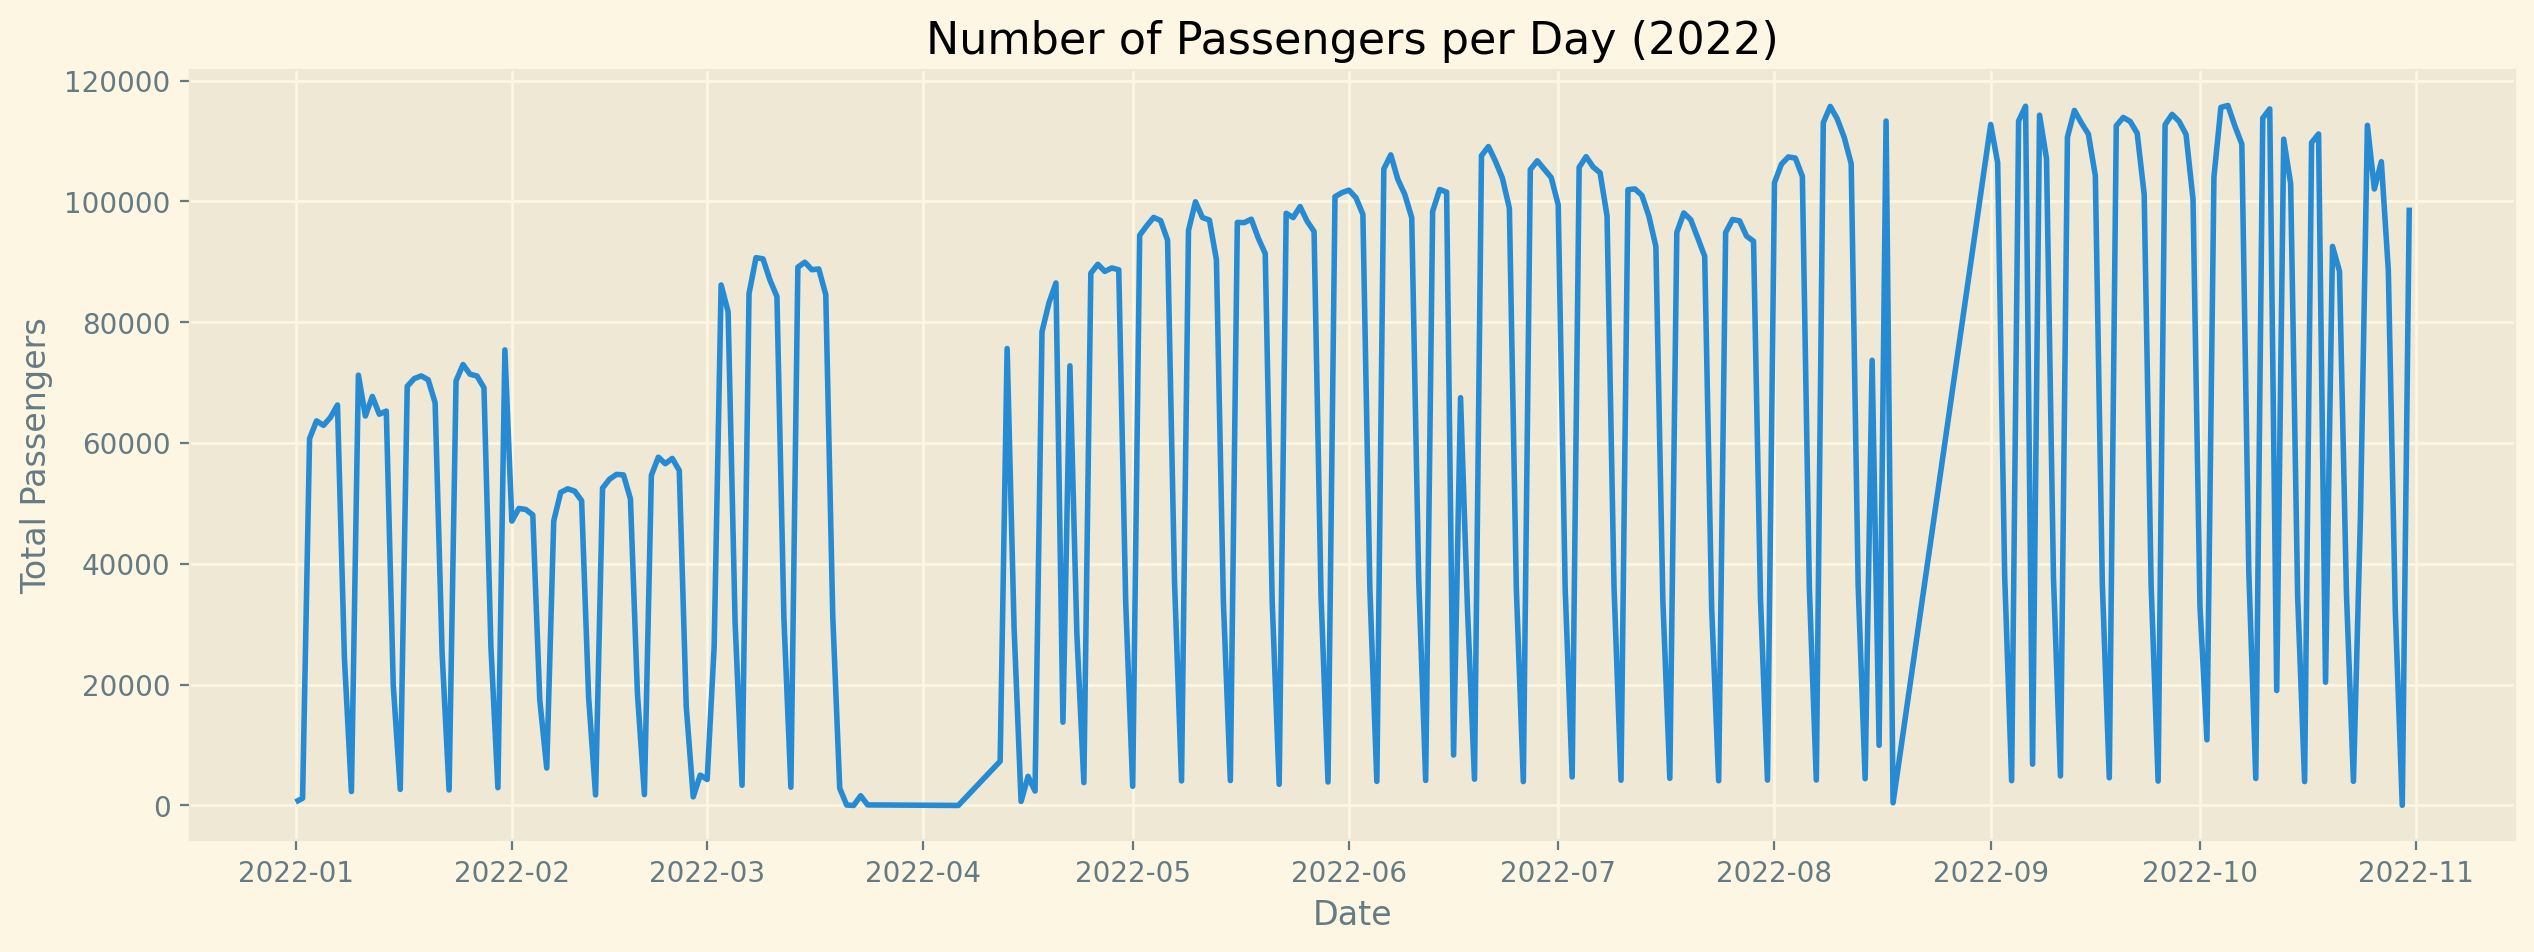

In [ ]:
# Function to plot the time series
def plot_time_series(data, x_column, y_column, title="Time Series", xlabel="Days", ylabel="Passengers"):
    # Set the size of the plot
    plt.figure(figsize=(15, 5))
    
    # Create the time series line plot using Seaborn
    sns.lineplot(data=data, x=x_column, y=y_column)
    
    # Set the labels and title
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    
    # Display the plot
    plt.show()

# Calling the function with the 2022 data
plot_time_series(
    data=freq_pas,
    x_column="Data Coleta",
    y_column="Passageiros",
    title="Number of Passengers per Day (2022)",
    xlabel="Date",
    ylabel="Total Passengers"
)

O gráfico da série temporal indica que existe uma sazonalidade semanal, mas também evidencia problemas que precisaremos tratar para realizar a previsão com a série temporal. O mais evidente desses problemas é o período zerado, que corresponde a uma greve de 23 dias dos motoristas e cobradores de ônibus. Outro fator que pode prejudicar a criação de uma previsão precisa são os feriados, pois nesses dias ocorre uma diminuição significativa do número de passageiros. 

Link notícia greve: https://g1.globo.com/pi/piaui/noticia/2022/04/12/chega-ao-fim-greve-de-motoristas-e-cobradores-de-onibus-em-teresina-apos-23-dias.ghtml

A tabela a seguir apresenta as medidas descritivas mais importantes, destacando o problema dos valores mínimos. O único dia que possui um valor mais próximo da realidade é o domingo.

É importante destacar que o valor mínimo irá influenciar tanto a média quanto o desvio-padrão, devido à sua inclusão nos cálculos dessas medidas.

In [5]:
# Function to calculate descriptive statistics by day of the week
def calcular_medidas(data, group_col, target_col):
    # Group the data by the grouping column and return descriptive statistics
    descriptive_stats = (
        data.groupby(group_col)[target_col]
        .describe()
        .round(2)  # Round the values to 2 decimal places
        .reset_index()
        .set_index(group_col)  # Set the index to the grouping column
    )
    return descriptive_stats

# Execute the function with the frequency data
data_day = calcular_medidas(freq_pas, group_col="dia_semana", target_col="Passageiros")
data_day

,count,mean,std,min,25%,50%,75%,max
dia_semana,,,,,,,,
0,40.0,83984.00,30549.58,26.0,71009.00,95048.5,105303.75,113803.0
1,39.0,84991.46,33666.52,1.0,67575.50,97335.0,108405.00,115768.0
2,40.0,79814.40,34240.50,0.0,61350.00,96884.0,104107.25,115903.0
3,40.0,81796.85,33022.00,89.0,64648.50,94128.0,105211.00,114292.0
4,38.0,84476.00,22282.10,672.0,70071.75,91140.5,99307.00,109493.0
5,39.0,30102.05,8988.70,575.0,27221.50,33653.0,35988.00,38663.0
6,39.0,3706.67,1667.67,23.0,2900.00,3984.0,4200.00,10867.0


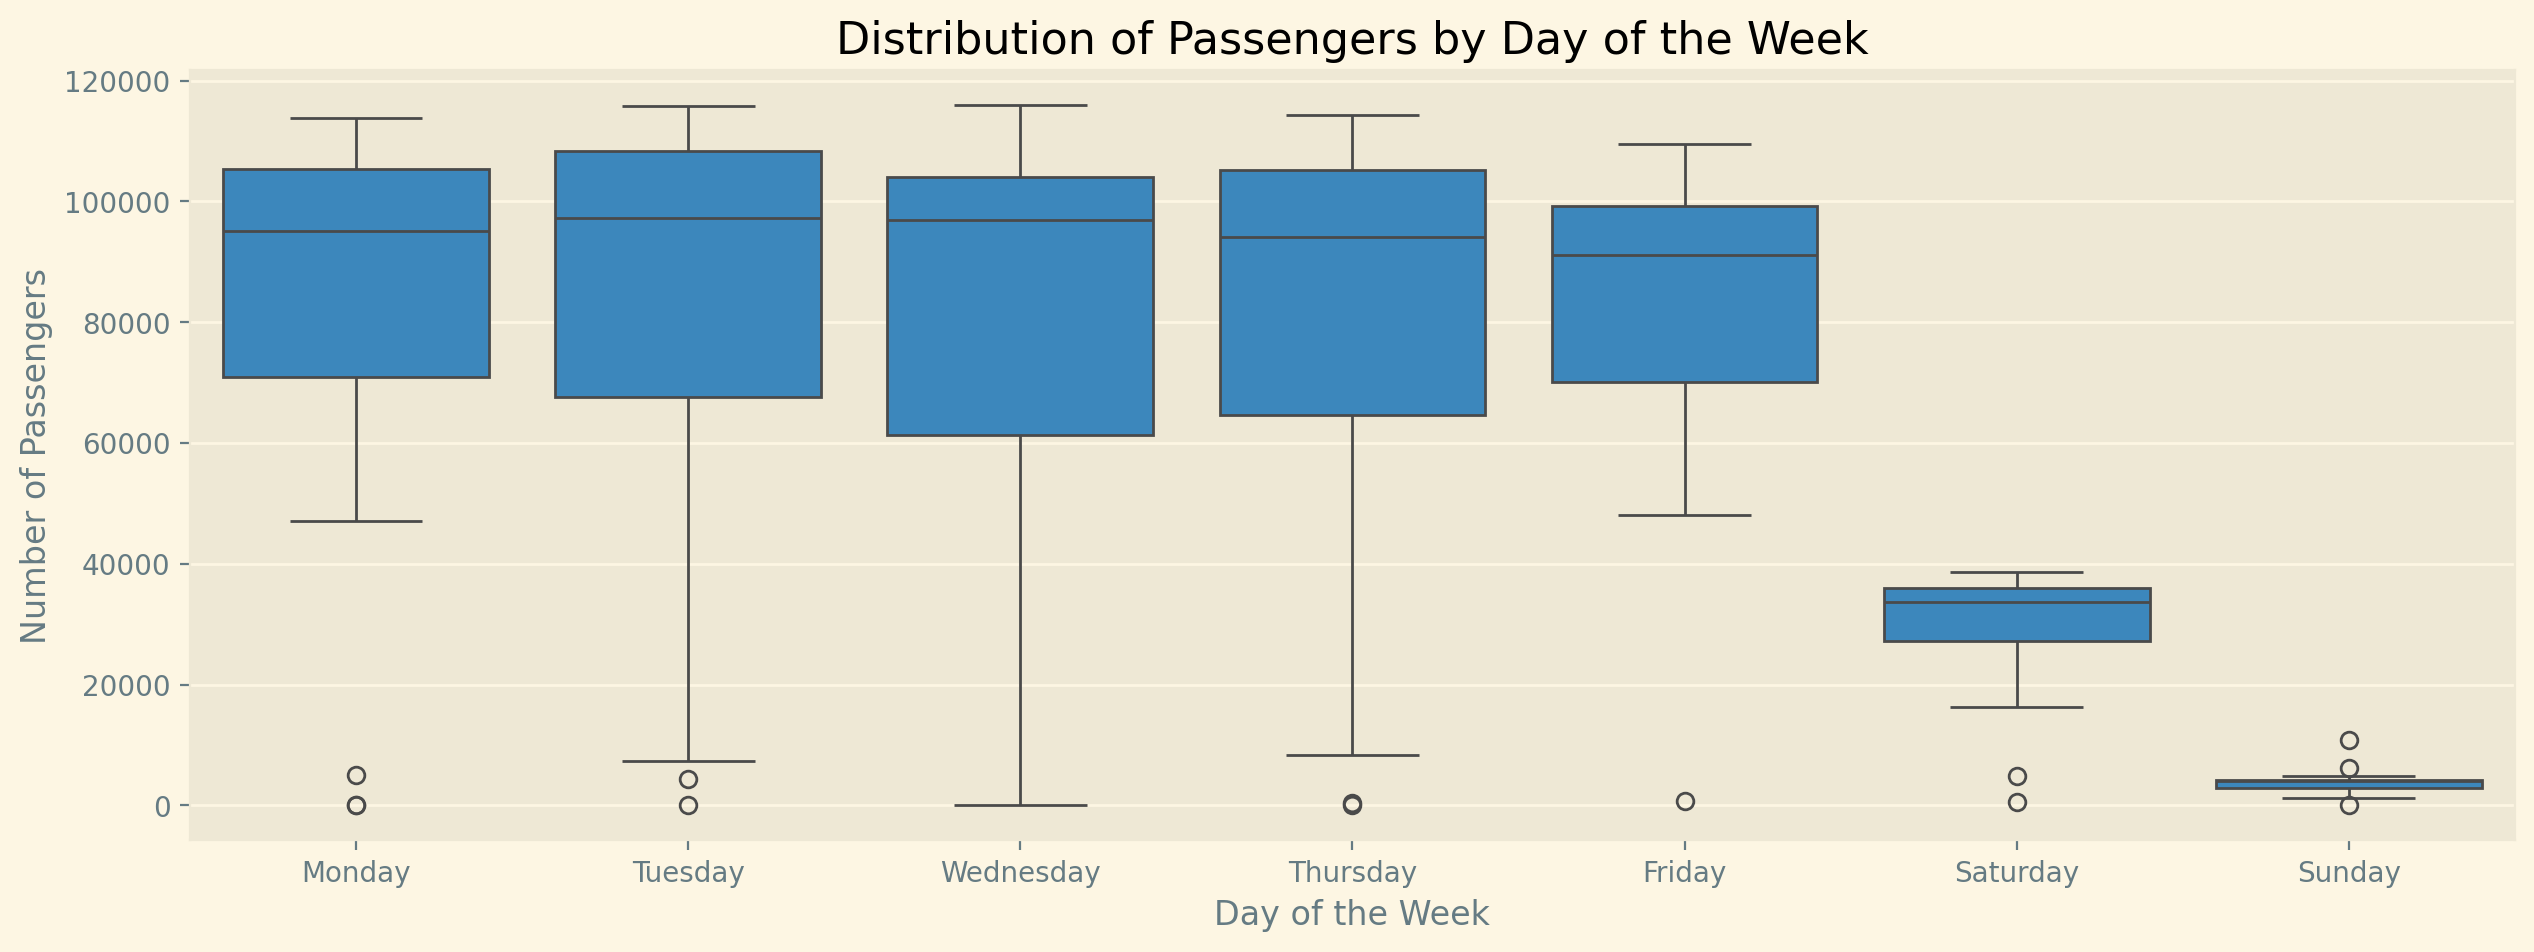

In [6]:
# Function to create a boxplot of passengers by day of the week
def boxplot_dias_semana(data, x_col, y_col, dias=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]):
    # Set the size of the plot
    plt.figure(figsize=(15, 5))
    
    # Create the boxplot using Seaborn
    sns.boxplot(data=data, x=x_col, y=y_col)
    
    # Customize the axis labels
    plt.xlabel("Day of the Week", fontsize=12)
    plt.ylabel("Number of Passengers", fontsize=12)
    plt.title("Distribution of Passengers by Day of the Week", fontsize=16)
    
    # Replace the day numbers with their respective names
    # (assumes that x_col contains numbers from 0 to 6 representing the days of the week)
    plt.xticks(ticks=range(len(dias)), labels=dias, fontsize=10)
    
    # Display the plot
    plt.show()

# Calling the function with the data
boxplot_dias_semana(
    data=freq_pas,
    x_col="dia_semana",
    y_col="Passageiros"
)

# Correção dos dados

Diante desses dados inexistentes e irreais, será necessário definir estimadores para substituir os valores. Para isso, o primeiro procedimento foi retirar os valores muito baixos e muito altos, ou seja, os outliers existentes no gráfico.

Para os dias úteis, limitamos esses valores a 50 mil como limite inferior e 125 mil como limite superior. Para os sábados, o limite inferior foi estabelecido em 18 mil e o limite superior em 40 mil. Para os domingos, impusemos um limite mínimo de 1.000 e um máximo de 15 mil.

Na tabela abaixo, podemos observar medidas descritivas mais realistas, e o box-plot confirma essas informações de forma gráfica.

Com essas medidas, podemos estabelecer valores para substituir os dados ausentes ou incorretos. 

In [7]:
# Define thresholds by day of the week
thresholds = {
    0: (50000, 125000),  # Weekdays (Monday to Thursday, assuming 0-4 are weekdays)
    1: (50000, 125000),
    2: (50000, 125000),
    3: (50000, 125000),
    4: (50000, 125000),
    5: (18000, 40000),   # Saturday
    6: (1000, 15000)     # Sunday
}

# Apply filters using the defined thresholds
for day, (low, high) in thresholds.items():
    freq_pas = freq_pas.drop(freq_pas[(freq_pas.dia_semana == day) & 
                                      ((freq_pas.Passageiros < low) | (freq_pas.Passageiros > high))].index)

In [8]:
data_day_c = calcular_medidas(freq_pas, group_col="dia_semana", target_col="Passageiros")
data_day_c

,count,mean,std,min,25%,50%,75%,max
dia_semana,,,,,,,,
0,35.0,93128.57,17542.89,52544.0,81602.50,98049.0,105528.00,113803.0
1,34.0,95470.79,19464.42,51836.0,89685.50,100708.5,110655.75,115768.0
2,33.0,93007.79,18655.03,52430.0,86512.00,97360.0,105721.00,115903.0
3,34.0,93262.38,18182.69,52045.0,87449.25,96885.5,107036.50,114292.0
4,36.0,87814.36,16581.05,50460.0,79509.00,91960.5,99689.00,109493.0
5,34.0,32846.41,4946.92,18552.0,31635.25,34062.5,36134.75,38663.0
6,38.0,3803.61,1574.77,1188.0,2960.00,3987.0,4201.00,10867.0


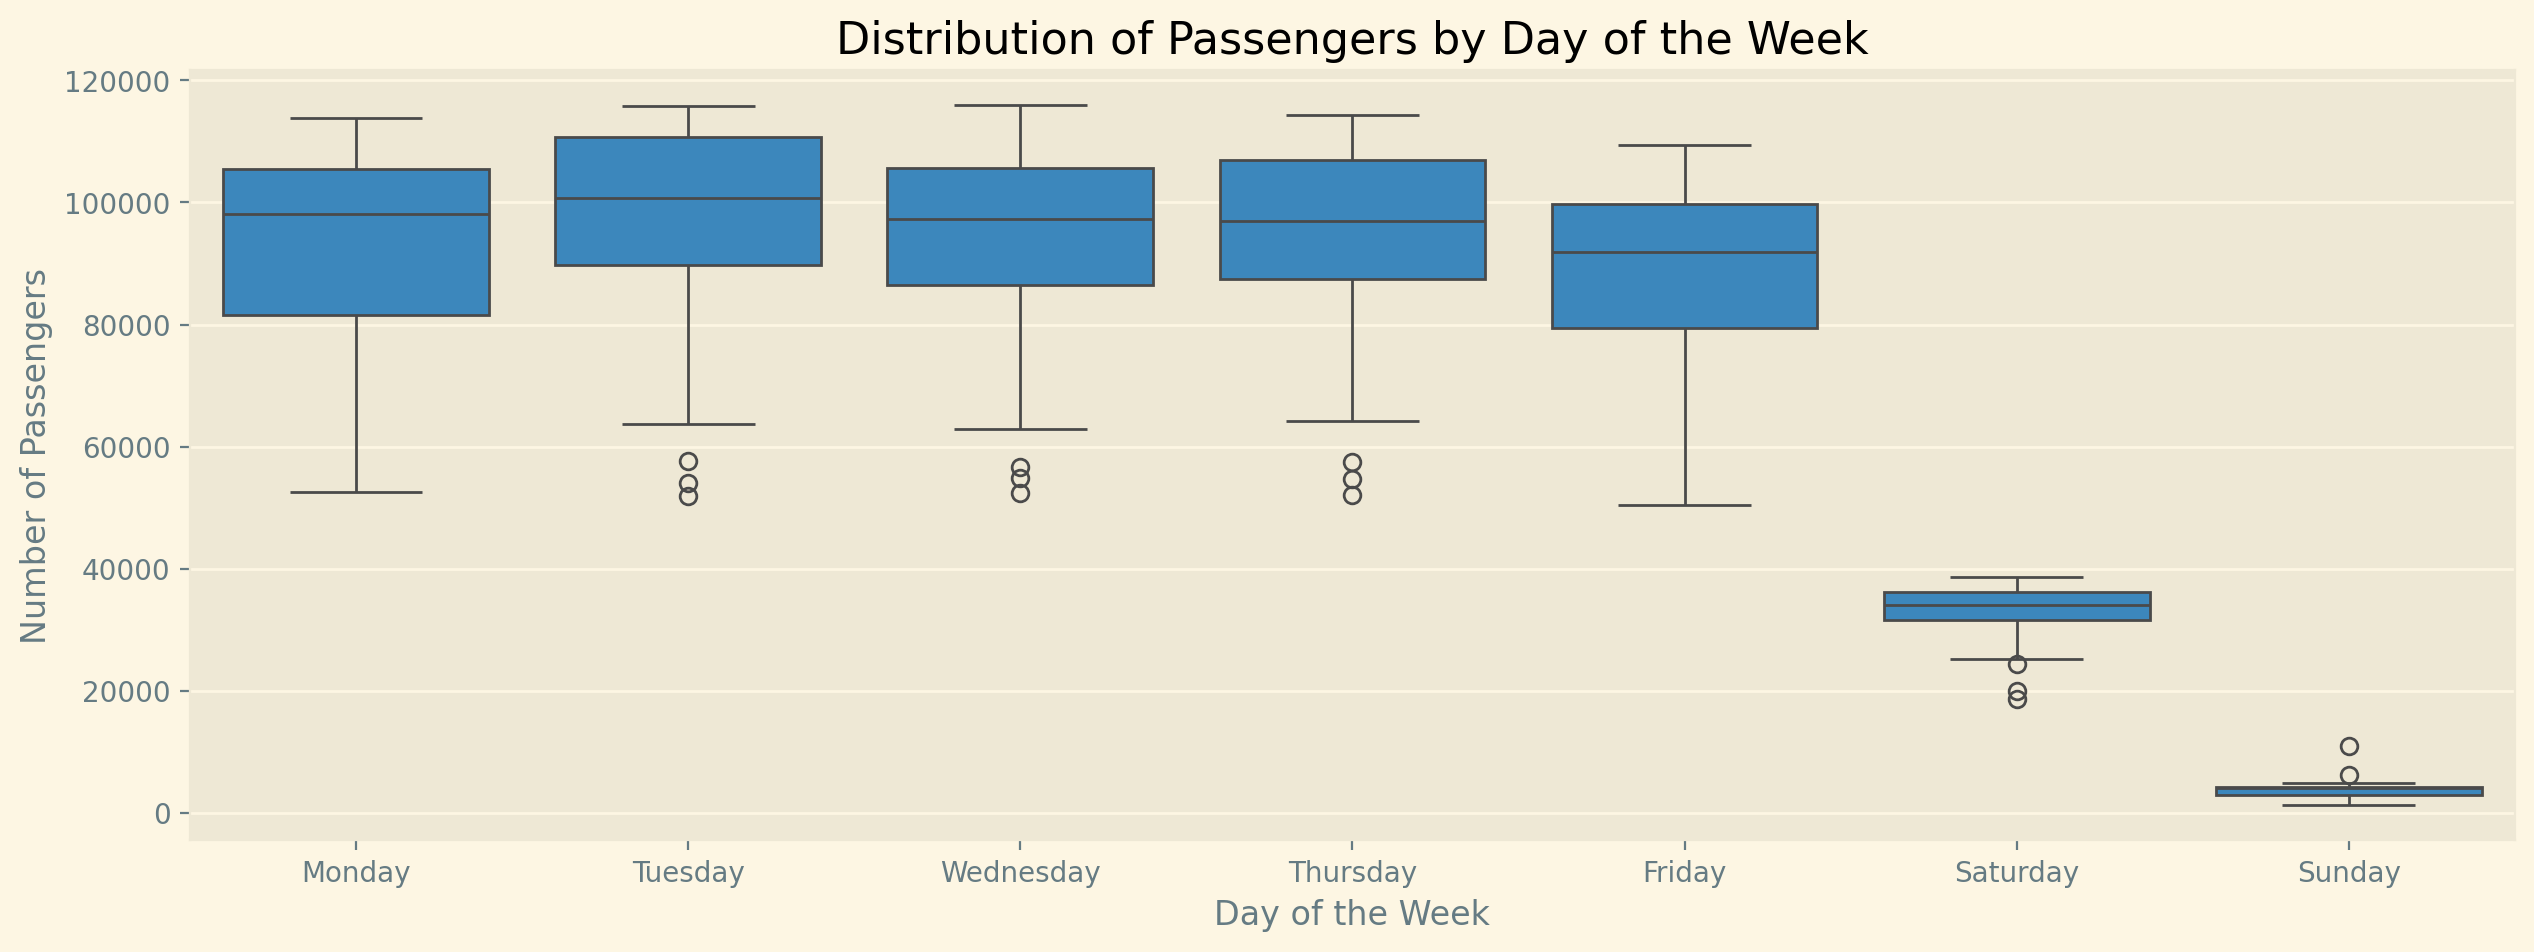

In [9]:
boxplot_dias_semana(
    data=freq_pas,
    x_col="dia_semana",
    y_col="Passageiros"
)

Diante dos outliers presentes, provenientes dos feriados, e dos dias sem contagem devido à greve, precisamos encontrar uma forma de substituir esses valores.

O procedimento de médias móveis para substituir dados ausentes poderia ser adequado ao contexto deste trabalho; contudo, visando preservar os valores diários e respeitar suas particularidades, optou-se por uma metodologia que leva em consideração a distribuição dos dados por dia da semana. Nesse formato, cada dia foi analisado isoladamente para capturar padrões específicos da variabilidade semanal. Adicionalmente, foi realizado o teste de normalidade de Shapiro-Wilk para cada conjunto de dados correspondente a um dia da semana. Quando a normalidade era detectada, os valores ausentes ou inconsistentes foram substituídos pela média do respectivo dia da semana. Por outro lado, caso a normalidade não fosse confirmada, os valores foram imputados utilizando a mediana.

O teste de  Shapiro-Wilk tem como hipótese nula ($H{0}$) a normalidade dos dados e como hipótese alternativa ($H{1}$) a não normalidade. Adotamos o valor de significância padrão de 0,05, o que corresponde a um intervalo de confiança de 95%.

Este método foi escolhido devido à observação de que o comportamento dos dados varia significativamente entre os diferentes dias da semana. Para evitar alterações na distribuição original dos dados e garantir a integridade das análises subsequentes, optou-se por uma abordagem que trata os dados considerando sua segmentação por dia da semana.

In [10]:
def shapiro_test_days(freq_pas):
    # Perform Shapiro-Wilk test for each day of the week
    shapiro_results = []

    for day in range(7):  # Iterate over all days, regardless of data availability
        day_data = freq_pas[freq_pas['dia_semana'] == day]['Passageiros']

        if len(day_data) > 3:  # Ensure enough data to apply the test
            _, shapiro_pvalue = stats.shapiro(day_data)
        else:
            shapiro_pvalue = None  # Not enough data for the test

        shapiro_results.append({'dia_semana': day, 'pvalor': shapiro_pvalue})

    # Compile the results into a DataFrame
    return pd.DataFrame(shapiro_results).round(5)

shapiro_day = shapiro_test_days(freq_pas)
shapiro_day

,dia_semana,pvalor
0,0,0.00450
1,1,0.00062
2,2,0.00244
3,3,0.00114
4,4,0.00333
5,5,0.00022
6,6,0.00000


Outro obstáculo a ser superado é a ausência de registros em determinados dias na tabela. Devido à greve, houve dias em que não houve registro de passageiros, e esses dias não estão nem mesmo zerados. A solução encontrada foi construir um data.frame com todos os dias do ano até a última data de registro utilizada na análise, que é a data limite utilizada para a construção da previsão. A segunda etapa consistiu em unir as tabelas e substituir os valores NA por 0. Construímos a função **generate_full_days_2022()** para este procedimento.

In [11]:
def generate_full_days_2022(freq_pas):
    # Extract the last date from the provided data
    last_day = freq_pas['Data Coleta'].max()

    # Create a date range for all days in 2022 up to the last analyzed date
    days_2022 = pd.date_range(start='2022-01-02', end=last_day)

    # Generate a full dataset of days by creating a new DataFrame
    days_full = pd.DataFrame({'Data Coleta': days_2022})

    # Merge the generated dates with the original dataset (fill missing passenger counts with 0)
    days_merge = pd.merge(days_full, freq_pas[['Data Coleta', 'Passageiros']], 
                          how='left', on='Data Coleta')
    days_merge['Passageiros'] = days_merge['Passageiros'].fillna(0)

    # Add a new column for the day of the week (Monday = 0, Sunday = 6)
    days_merge['dia_semana'] = days_merge['Data Coleta'].dt.dayofweek

    return days_merge

# Update freq_pas with the new dataset
freq_pas = generate_full_days_2022(freq_pas)
freq_pas

,Data Coleta,Passageiros,dia_semana
0,2022-01-02,1188.0,6
1,2022-01-03,60738.0,0
2,2022-01-04,63675.0,1
3,2022-01-05,62938.0,2
4,2022-01-06,64257.0,3
...,...,...,...
298,2022-10-27,106588.0,3
299,2022-10-28,88615.0,4
300,2022-10-29,32275.0,5
301,2022-10-30,0.0,6


Com a tabela construída, contendo os valores 0, realizamos a alteração desses valores de acordo com os valores estabelecidos na tabela sem os valores irreais. O valor será substituído conforme o resultado do teste de normalidade.

In [12]:
# Loop through each day of the week
for i in range(7):
    # Determine the replacement value based on Shapiro-Wilk p-value
    replacement_value = np.where(
        shapiro_day['pvalor'][i] > 0.05,  # Condition to check p-value
        data_day_c['mean'][i],           # Use mean if p-value > 0.05
        data_day_c['50%'][i]             # Use 50th percentile (median) otherwise
    )
    
    # Replace `Passageiros` where conditions are met
    freq_pas['Passageiros'] = np.where(
        (freq_pas['Passageiros'] == 0) & 
        (freq_pas['dia_semana'] == i) &
        (freq_pas['Data Coleta'] > '2022-01-31') &
        (freq_pas['Data Coleta'] < '2022-09-30'),
        replacement_value,  # Replace with the chosen value
        freq_pas['Passageiros']  # Keep original value otherwise
    )


In [37]:
for i in range(7):
    if shapiro_day['pvalor'][i] > 0.05:
        freq_pas['Passageiros']  = np.where((freq_pas['Passageiros'] == 0) 
        & (freq_pas['dia_semana'] == i) 
        & (freq_pas['Data Coleta'] > '2022-01-31') & (freq_pas['Data Coleta'] < '2022-09-30'), data_day_c['mean'][i], freq_pas['Passageiros'])
    
    else:                                     
        freq_pas['Passageiros']  = np.where((freq_pas['Passageiros'] == 0 ) 
        & (freq_pas['dia_semana'] == i) 
        & (freq_pas['Data Coleta'] > '2022-01-31') & (freq_pas['Data Coleta'] < '2022-09-30'), data_day_c['50%'][i] , freq_pas['Passageiros'])

Para confirmar alteraçãos dos valores, vizuallizamos o box-plot novamente. Percebemos a correção implantanda. 

O segundo gráfico  mostra  a linha temporal corrigida. 

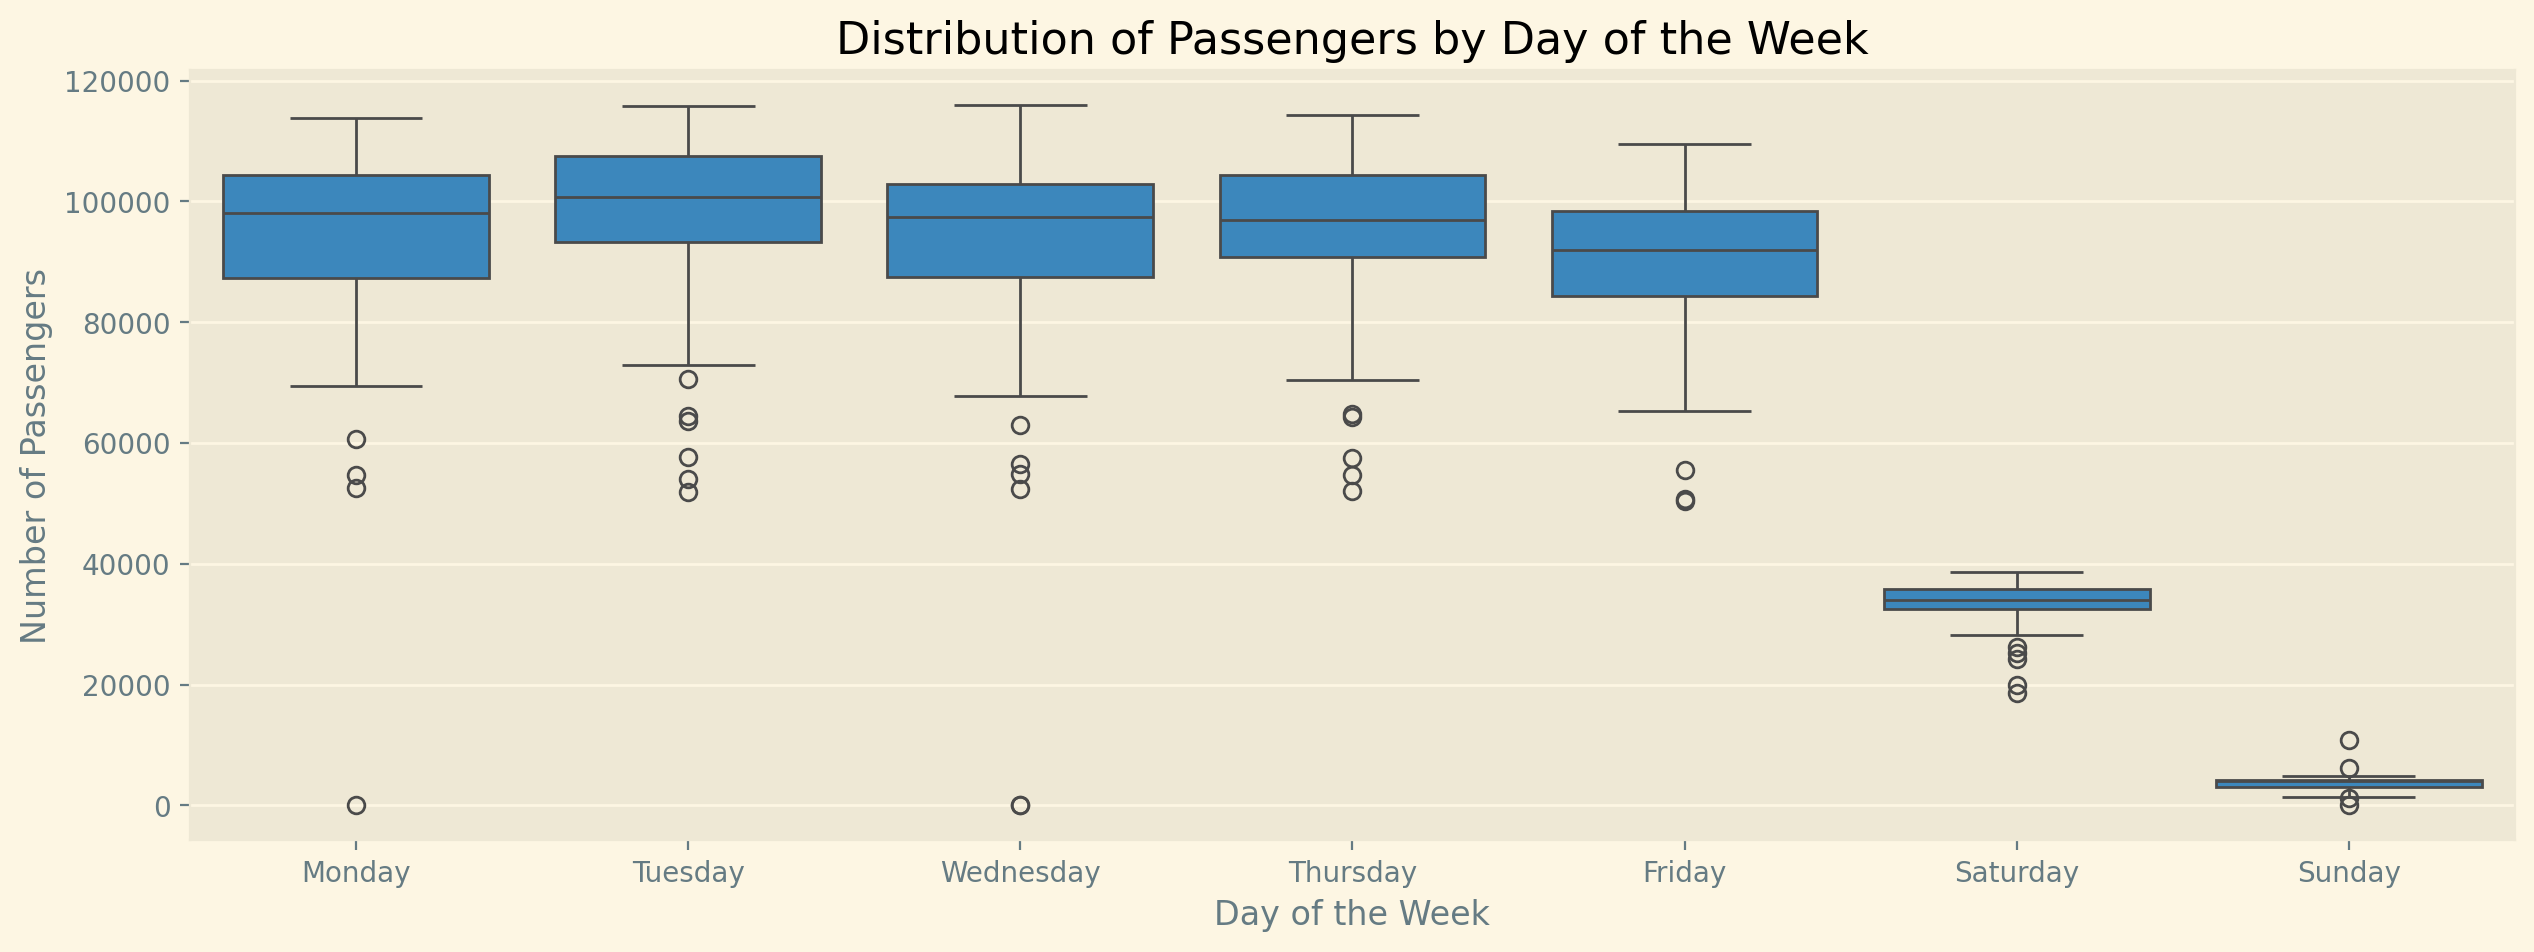

In [13]:
boxplot_dias_semana(
    data=freq_pas,
    x_col="dia_semana",
    y_col="Passageiros"
)

Observou-se que existem valores zerados para as segundas e quartas-feiras na série histórica. Isso ocorre em função do fato de a correção dos dados ter sido limitada até o mês de setembro. Essa decisão foi tomada intencionalmente, visto que o objetivo é construir os modelos de previsão para o mês subsequente, outubro, que é o último mês da série histórica estudada.

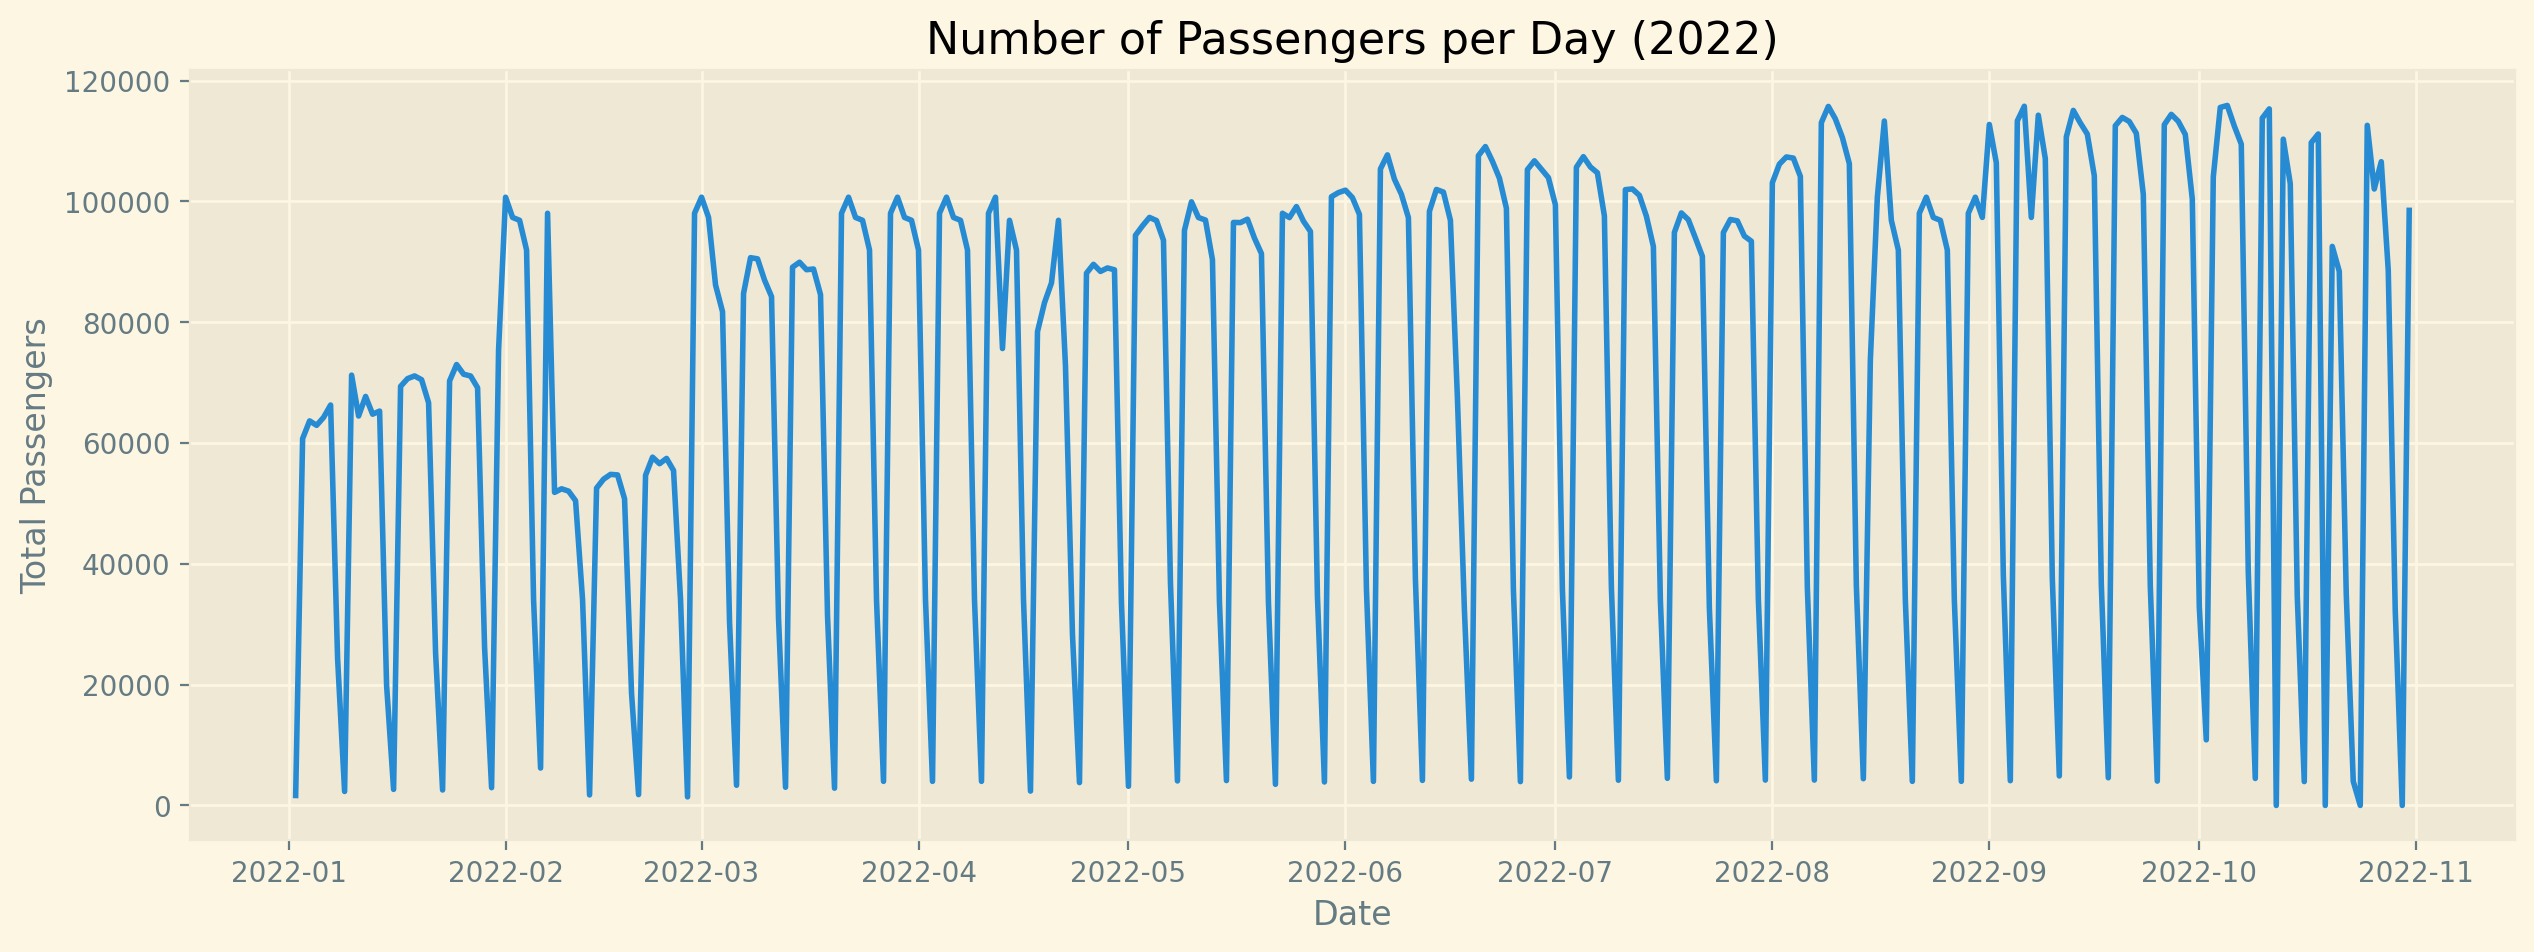

In [15]:
# Calling the function with the 2022 data
plot_time_series(
    data=freq_pas,
    x_column="Data Coleta",
    y_column="Passageiros",
    title="Number of Passengers per Day (2022)",
    xlabel="Date",
    ylabel="Total Passengers"
)

Para os modelos de previsão, iremos utilizar a série corrigida que ainda apresenta um comportamento influenciado pelas oscilações não previstas, só que em um grau menor, todavia, após um períodos mensais por exemplo, é importante realizar a construção de outro modelo de previsão da série e avaliar as mundanças no modelo criado.

Outro processo futuro é acompanhar a estabilização da frequência de passageiros. Podemos observar no gráfico que há uma diferença nos valores de passageiros ao comparar o primeiro e o segundo semestre, resultado de um aumento no número de pessoas transportadas. No segundo semestre, os passageiros em dias úteis superam os 100 mil, todavia, esse comportamento só se estabilizou em maio e ocorreu outro incremento a partir de agosto, quando os valores se aproximam dos 120 mil passageiros

# Previsão de passageiros

Na criação de de modelos, iremos utilizar dois tipos de algoritmos mais modernos que os tradicionais de médias móveis e regressivos. São o Prophet, modelo desenvolvido pelo Facebook e o com o uso de redes LSTM, rede neural do tipo recorrente, muito utilizado com dados sequenciais. 

## Séries Temporais com Prophet

O Prophet é uma biblioteca de código aberto desenvolvida pela Meta (antigo Facebook) especificamente para modelagem e previsão de séries temporais. Ele foi projetado com foco na facilidade de uso, permitindo que até mesmo usuários sem profunda experiência em estatística ou machine learning consigam realizar previsões com eficiência. A ferramenta é particularmente útil para lidar com séries temporais que possuem padrões sazonais ou mudanças de tendência. 

A exigência do método consiste em usar colunas com datas nomeadas de "ds" e de valores de "y"

In [50]:
# Select the relevant columns from the original DataFrame ('Data Coleta' and 'Passageiros')
df_prophet = freq_pas[['Data Coleta', 'Passageiros']]

# Rename the columns to fit Prophet's requirements ('ds' for dates, 'y' for the target variable)
df_prophet = df_prophet.rename(columns={'Data Coleta': 'ds', 'Passageiros': 'y'})

# Split the data into training (all rows except the last 30) and testing (last 30 rows)
train = df_prophet[:-30]  # Training set: used for model fitting
test = df_prophet[-30:]   # Testing set: used for model evaluation

# Create a new instance of the Prophet forecasting model (using default parameters)
model = Prophet()

# Train the Prophet model using the training dataset
model.fit(train)

# Create a DataFrame that includes all training dates plus 30 additional future dates for forecasting
future = model.make_future_dataframe(periods=30)

# Use the fitted model to predict values for all dates in the 'future' DataFrame
forecast = model.predict(future)

19:57:12 - cmdstanpy - INFO - Chain [1] start processing
19:57:12 - cmdstanpy - INFO - Chain [1] done processing


Adentrando em dois coceitos básico de séries temporais, temos Tendência e sazonalidade que são componentes fundamentais na análise de séries temporais, ajudando a identificar padrões de comportamento nos dados ao longo do tempo. A tendência representa a direção geral de longo prazo — crescimento, declínio ou estabilidade — de uma variável, causada por fatores estruturais, econômicos ou sociais. Já a sazonalidade reflete flutuações periódicas que ocorrem em intervalos regulares, como picos ou quedas relacionados a estações do ano, meses ou dias, muitas vezes influenciados por costumes, clima ou eventos recorrentes

As imagens a seguir mostram, primeiramente a tendência, com um evolução crescente durante o ano do número de passageiros, de 55 mil para quase 85 mil. A segunda imagem é uma representação da sazonalidade semanal baixo número de passageiros durante o final de semana e comportamento constante durante dias úteis.

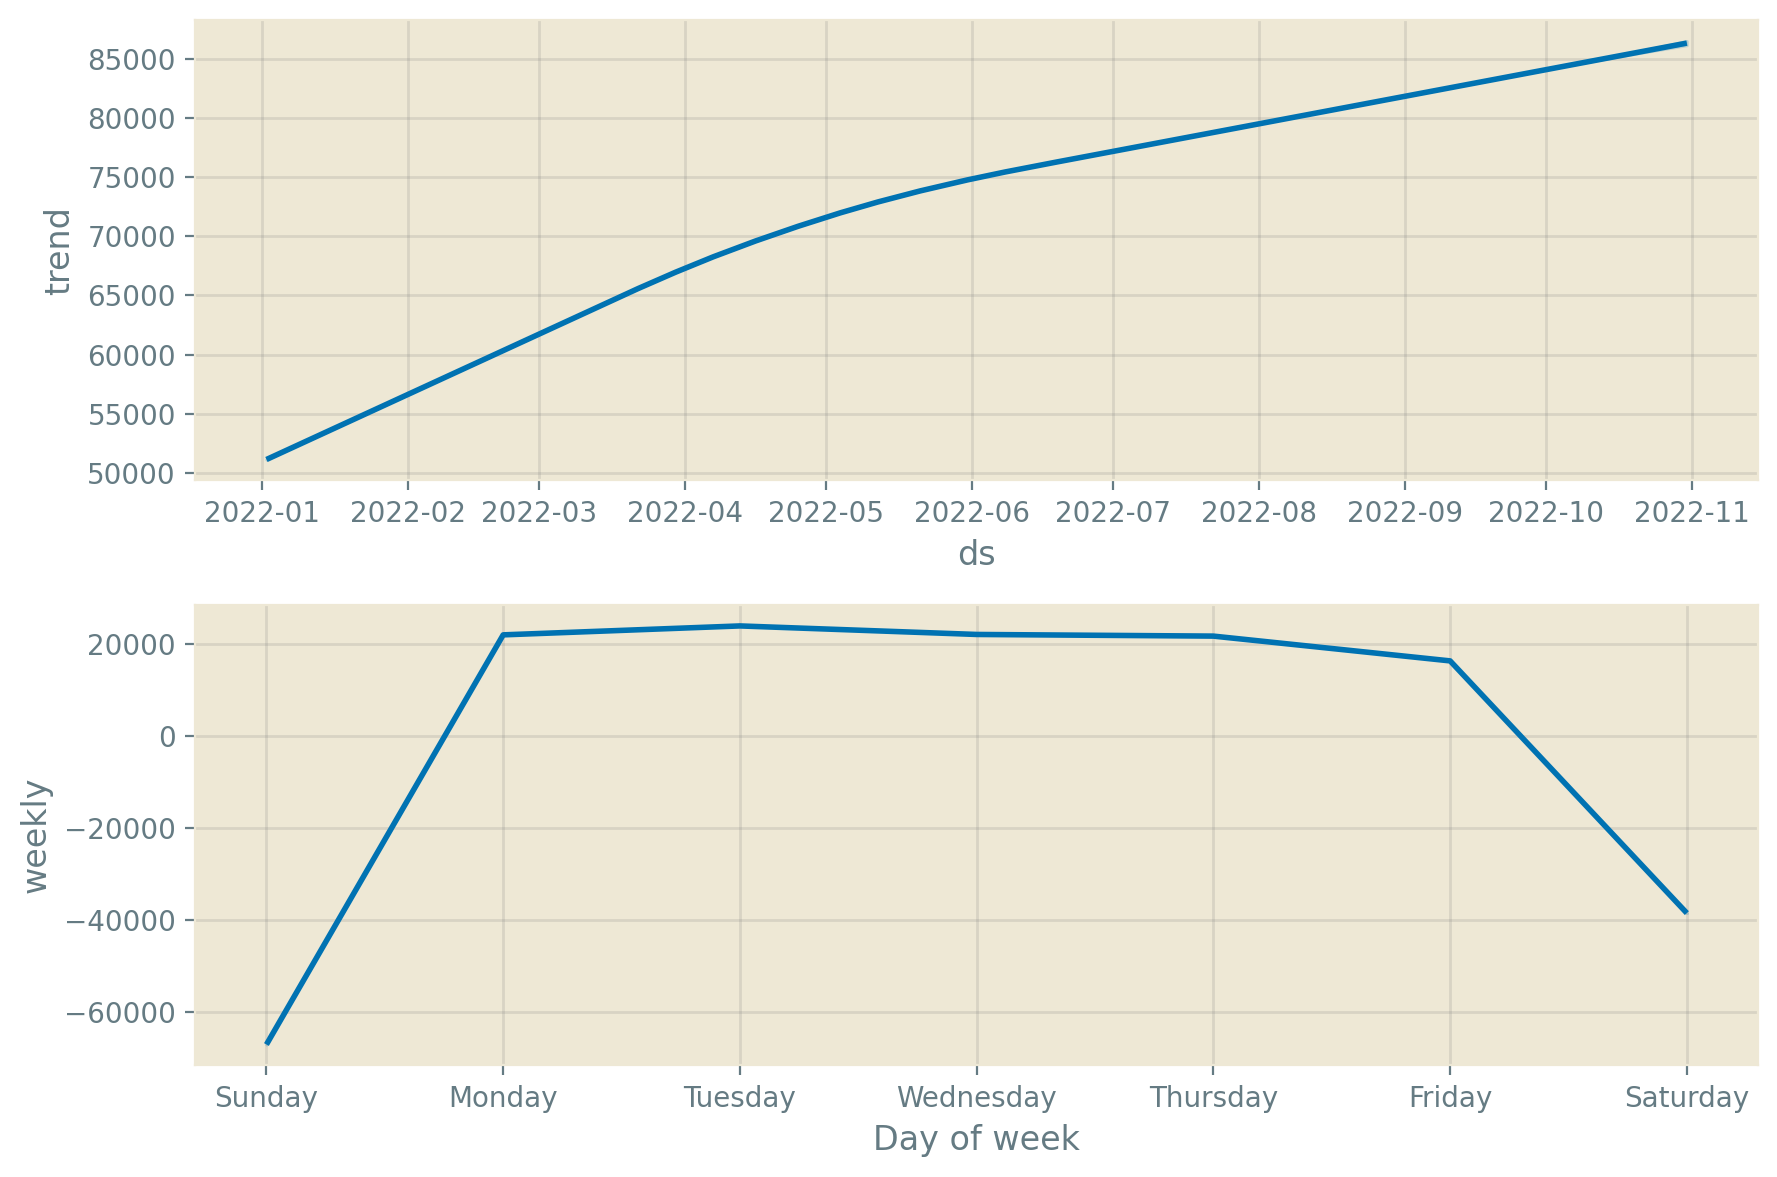

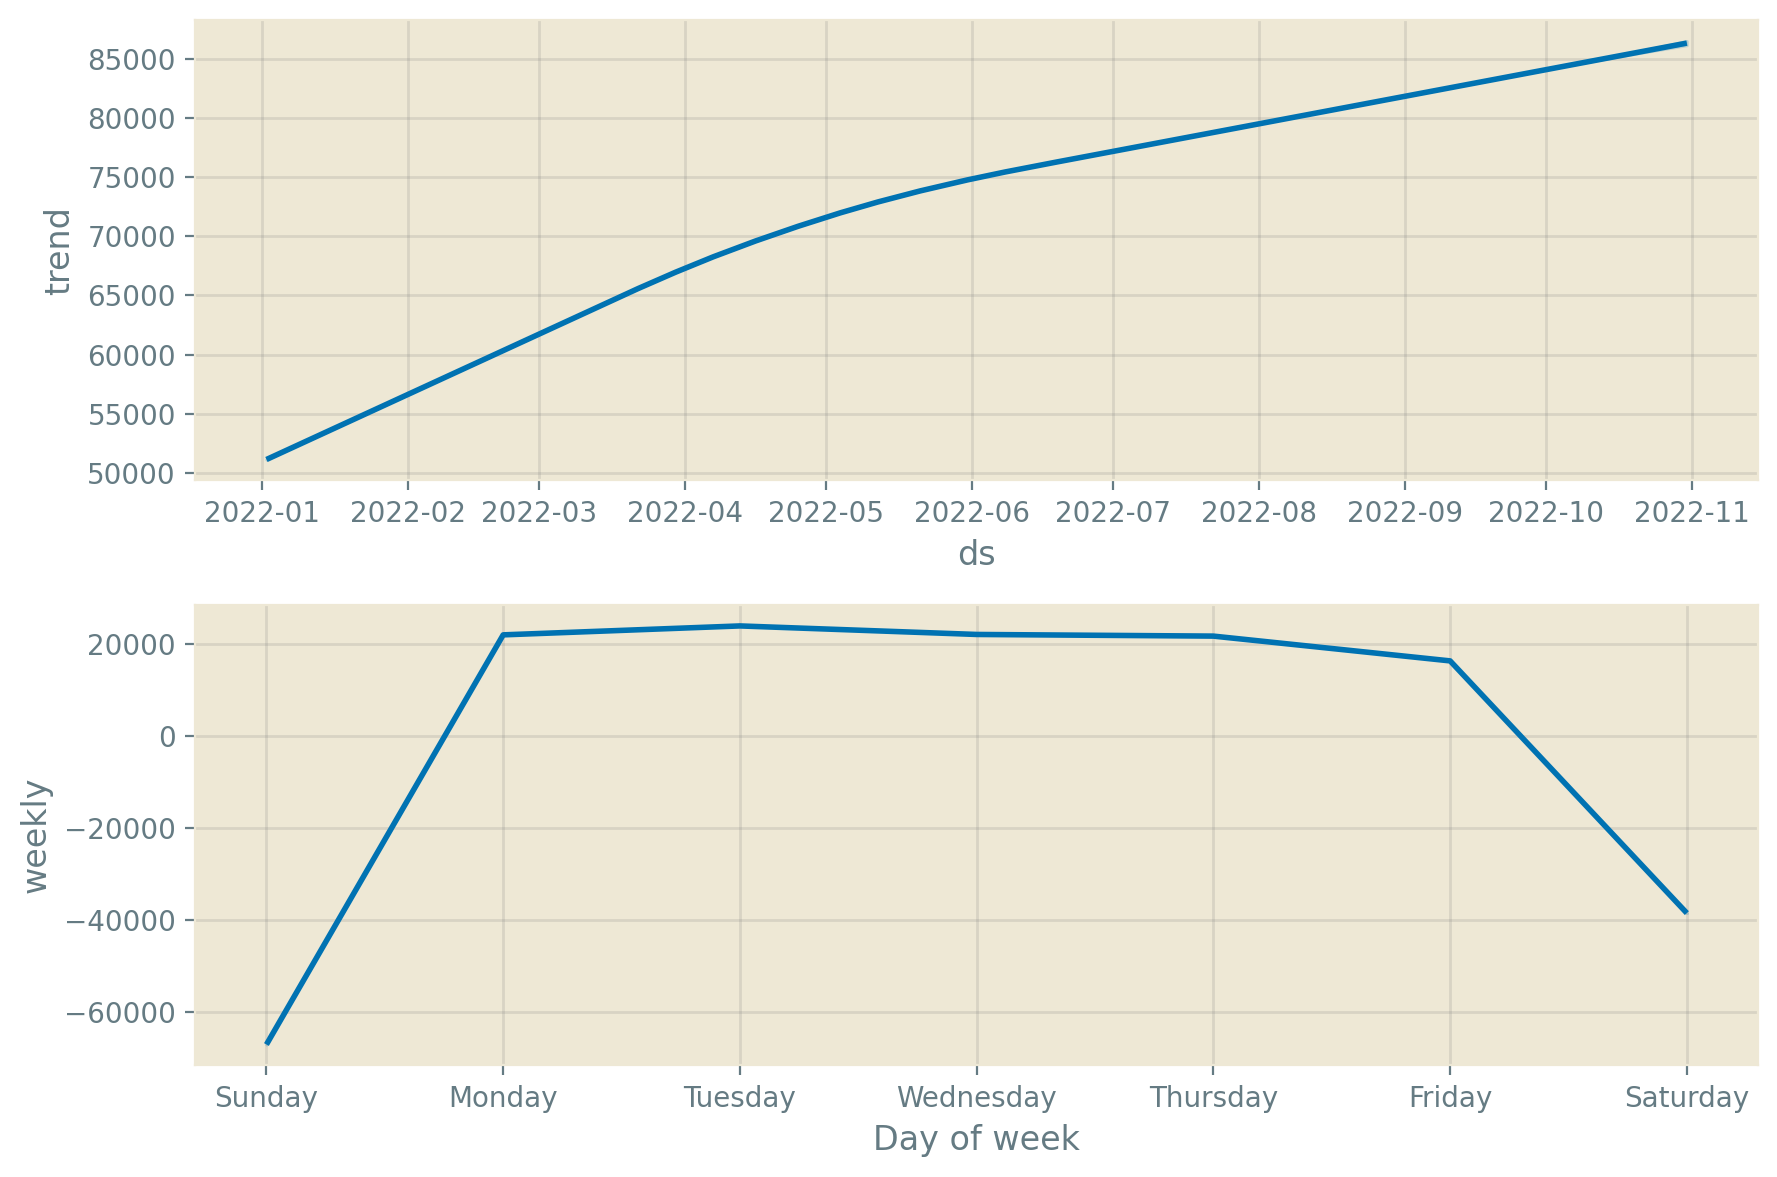

In [ ]:
plot_components(model, forecast) # plot the components

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10) # table with predictions

In [ ]:
# Extract the last 30 rows from the forecast DataFrame (corresponding to the prediction period)
# Select only the 'ds' (dates) and 'yhat' (predicted values) columns
# Reset the index to align it with the 'actuals' DataFrame for easy comparison
predictions = forecast[-30:][['ds', 'yhat']].reset_index(drop=True)

# Prepare the actual values from the test dataset (last 30 rows)
# Select the 'ds' (dates) and 'y' (actual target values) columns
# Reset the index to match the 'predictions' DataFrame for comparison purposes
actuals = test[['ds', 'y']].reset_index(drop=True)

# Calculate the Root Mean Squared Error (RMSE) between the actual values ('y') and predicted values ('yhat')
# RMSE is a commonly used metric to evaluate the accuracy of a forecasting model
rmse = np.sqrt(mean_squared_error(actuals['y'], predictions['yhat']))

# Print the RMSE value with two decimal precision to assess model performance
print(f'RMSE: {rmse:.2f}')

RMSE: 35241.15


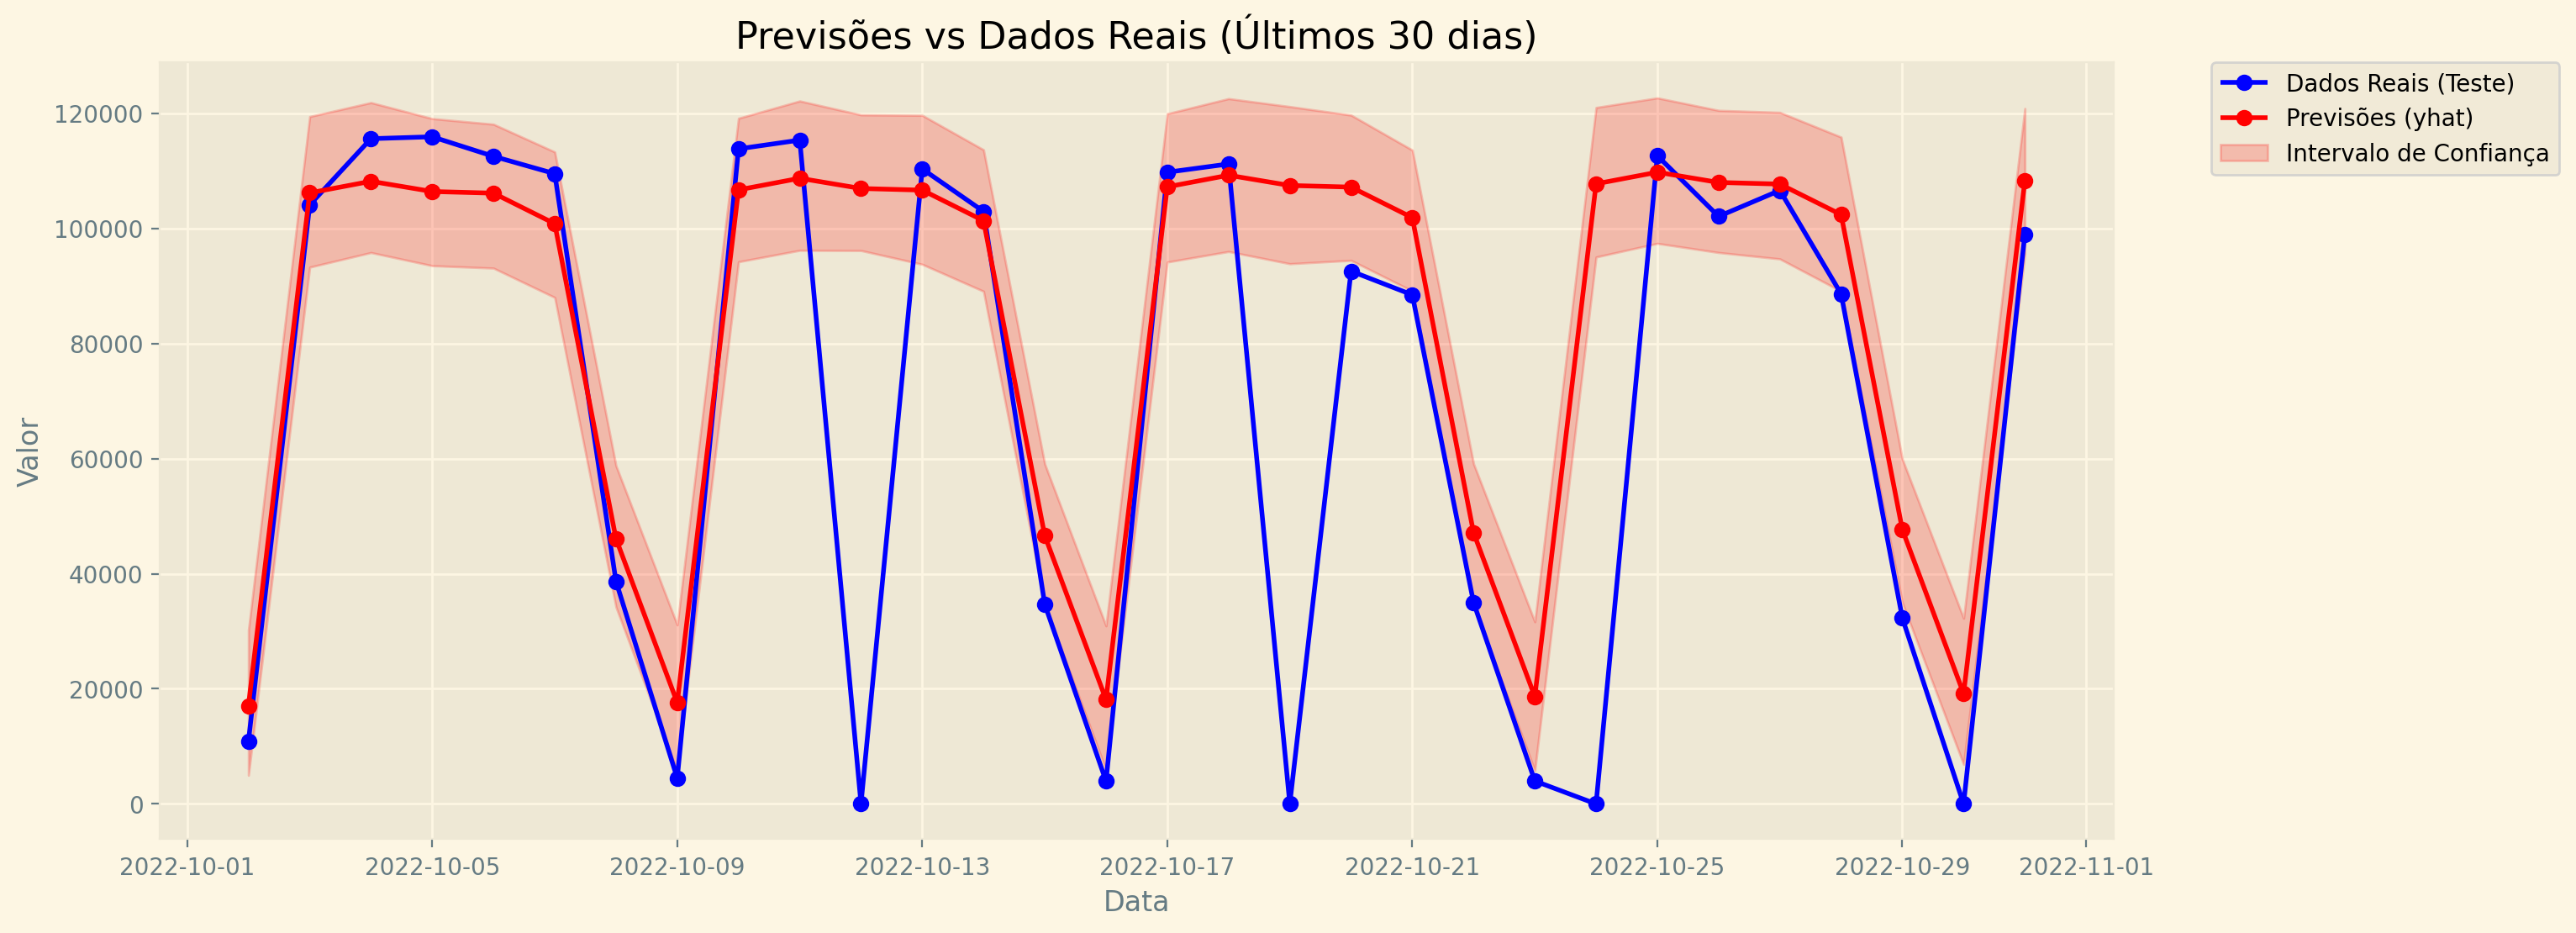

In [ ]:
plt.figure(figsize=(15, 6))


plt.plot(test['ds'], test['y'], label='Dados Reais (Teste)', color='blue', marker='o')


plt.plot(predictions['ds'], predictions['yhat'], label='Previsões (yhat)', color='red', marker='o')


plt.fill_between(
    predictions['ds'], 
    forecast[-30:]['yhat_lower'], 
    forecast[-30:]['yhat_upper'], 
    color='red', alpha=0.2, label='Intervalo de Confiança'
)

# Configurar o gráfico
plt.title('Previsões vs Dados Reais (Últimos 30 dias)')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.show()


O resultado obtido foi considerado satisfatório. Embora o modelo não tenha conseguido prever os dias com valores zerados, tal comportamento era esperado, já que a natureza da série indica que ela não deveria apresentar valores nulos em nenhum momento. Ainda assim, é importante destacar que os valores reais permaneceram dentro do intervalo de confiança estimado pelo algoritmo.

# Rede Neurais

Para este trabalho, iremos utilizar LTSM, que consiste numa variação do modelo de Rede Neural, do tipo recorrente e consiste num processo um pouco mais complexo, pois envolve a inclusão de elementos de "memorização" no interior das redes Neurais. Resumidamente, elementos de aproveitamento e descarte de informações são incluídas no interior da Rede Neural para aprendizagem da sequência em análise, como um série temporal. Para a construção do algoritmo utilizamos Pytorch.

Segue abaixo:

In [40]:
df =  freq_pas[['Data Coleta', 'Passageiros']]
df.set_index('Data Coleta', inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled'] = scaler.fit_transform(df[['Passageiros']])

train_size = len(df) - 30
train_data = df['scaled'][:train_size].values
test_data = df['scaled'][train_size:].values

In [41]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Configurar o comprimento da sequência
seq_length = 7

# Criar as sequências para treino e teste
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Ajustar os dados para 3 dimensões (necessário para o LSTM)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [ ]:
# Function to create input-output sequences for time-series data
def create_sequences(data, seq_length):
    X, y = [], []  # Lists to store input sequences (X) and their corresponding targets (y)
    
    # Loop over the data to create sequences of length `seq_length`
    for i in range(len(data) - seq_length):
        # Extract a sequence of length `seq_length` and append to X
        X.append(data[i:i+seq_length])
        # Append the next value in the series (value right after the sequence) as the target
        y.append(data[i+seq_length])
    
    # Convert the input (X) and target (y) lists to NumPy arrays for easier processing
    return np.array(X), np.array(y)


# Define the sequence length (number of past time steps to include in each input sequence)
seq_length = 7  # This will take the last 7 data points as input to predict the next data point


# Create sequences for training data
X_train, y_train = create_sequences(train_data, seq_length)  # Training input (X) and output (y) pairs
# Create sequences for testing data
X_test, y_test = create_sequences(test_data, seq_length)  # Testing input (X) and output (y) pairs


# Reshape the input data into 3D arrays to make it compatible with LSTM requirements
# LSTMs in deep learning frameworks expect input data in the shape (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # 1 feature per time step (univariate data)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  # Similarly, reshape the testing data


# Convert the NumPy arrays into PyTorch tensors, as tensors are required for PyTorch models
# Tensors are multidimensional arrays optimized for GPU acceleration and deep learning
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Convert training input to PyTorch tensor
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Convert training target to PyTorch tensor

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Convert testing input to PyTorch tensor
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)  # Convert testing target to PyTorch tensor


In [ ]:
# Train the model
for epoch in range(num_epochs):  # Loop through the number of epochs specified for training
    model.train()  # Set the model to training mode (enables training-specific behaviors like dropout)
    optimizer.zero_grad()  # Clear previously accumulated gradients to prevent mix-up in gradient calculations
    
    # Forward pass: Pass the training data through the model to compute predictions
    outputs = model(X_train_tensor)  # Compute the model's predictions based on training data inputs
    
    # Compute the loss between the model's predictions and the true training labels
    # The squeeze() function removes unnecessary dimensions to match the expected shape of the labels
    loss = criterion(outputs.squeeze(), y_train_tensor)
    
    # Backward pass to compute gradients and update weights
    loss.backward()  # Compute the gradients of the loss with respect to model parameters
    optimizer.step()  # Use the computed gradients to perform an optimization step (update the model's weights)
    
    # Log training progress: Print the loss value every 10 epochs (or any interval of choice)
    if (epoch + 1) % 10 == 0:  # Check if the current epoch is a multiple of 10
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')  # Display the epoch and corresponding loss value

# Evaluate on the test set
model.eval()  # Set the model to evaluation mode (disables training-specific behaviors like dropout and batch normalization)
with torch.no_grad():  # Disable gradient calculations to save memory and speed up computation since no training is needed
    predictions = model(X_test_tensor).squeeze()  # Generate predictions on the test set and remove unnecessary dimensions

# Reverse normalization of the data to bring predictions and ground truth back to original scale
y_test_original = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))  # Reverse scale for true test labels
predictions_original = scaler.inverse_transform(predictions.numpy().reshape(-1, 1))  # Reverse scale for model predictions

# Calculate RMSE (Root Mean Squared Error) to measure prediction accuracy
rmse = np.sqrt(mean_squared_error(y_test_original, predictions_original))  # Compute RMSE between true and predicted values
print(f'RMSE: {rmse:.2f}')  # Print the RMSE value with two decimal precision for analysis


Epoch [10/500], Loss: 0.1933
Epoch [20/500], Loss: 0.1105
Epoch [30/500], Loss: 0.1122
Epoch [40/500], Loss: 0.1033
Epoch [50/500], Loss: 0.1038
Epoch [60/500], Loss: 0.1025
Epoch [70/500], Loss: 0.1021
Epoch [80/500], Loss: 0.1017
Epoch [90/500], Loss: 0.1010
Epoch [100/500], Loss: 0.1002
Epoch [110/500], Loss: 0.0990
Epoch [120/500], Loss: 0.0974
Epoch [130/500], Loss: 0.0951
Epoch [140/500], Loss: 0.0916
Epoch [150/500], Loss: 0.0857
Epoch [160/500], Loss: 0.0747
Epoch [170/500], Loss: 0.0556
Epoch [180/500], Loss: 0.0368
Epoch [190/500], Loss: 0.0278
Epoch [200/500], Loss: 0.0237
Epoch [210/500], Loss: 0.0189
Epoch [220/500], Loss: 0.0153
Epoch [230/500], Loss: 0.0123
Epoch [240/500], Loss: 0.0104
Epoch [250/500], Loss: 0.0094
Epoch [260/500], Loss: 0.0088
Epoch [270/500], Loss: 0.0084
Epoch [280/500], Loss: 0.0081
Epoch [290/500], Loss: 0.0078
Epoch [300/500], Loss: 0.0075
Epoch [310/500], Loss: 0.0072
Epoch [320/500], Loss: 0.0070
Epoch [330/500], Loss: 0.0068
Epoch [340/500], Lo

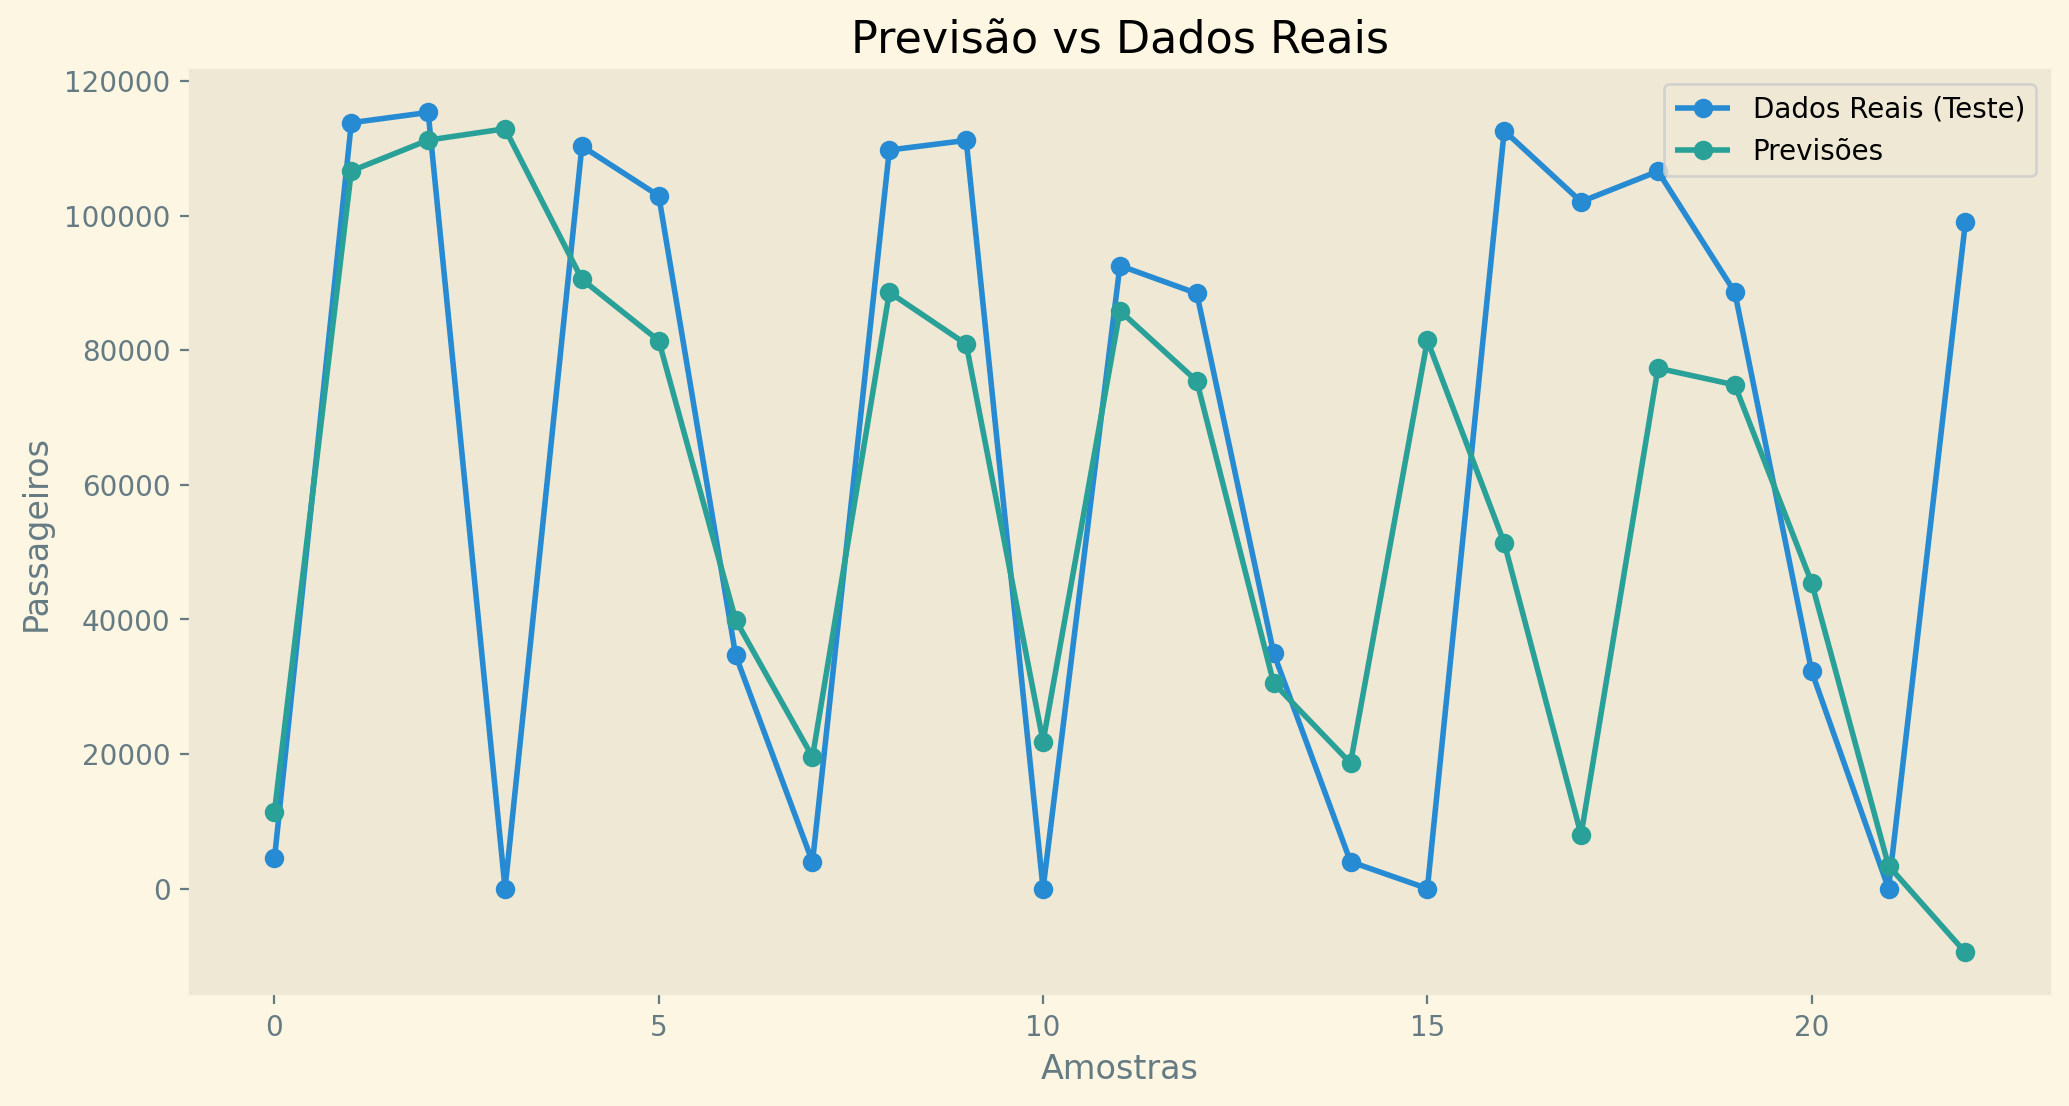

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_original)), y_test_original, label="Dados Reais (Teste)", marker='o')
plt.plot(range(len(predictions_original)), predictions_original, label="Previsões", marker='o')
plt.title('Previsão vs Dados Reais')
plt.xlabel('Amostras')
plt.ylabel('Passageiros')
plt.legend()
plt.grid()
plt.show()

## Conclusão 

Após a construção dos modelos, pode-se identificar que o modelo Prophet obteve os melhores resultados na predição de valores de treino. Dessa forma, este modelo seria o recomendado para a previsão da quantidade de passageiros. Todavia, é preciso acompanhamento constante para melhorias de modelos e adequação dos valores obtidos. 